In [1]:
import pnet_loader
import util
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import Pnet
import random
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import torch.nn.functional as F
import torch.nn as nn
import os

%load_ext autoreload
%autoreload 2

In [2]:
datapath='/mnt/disks/pancan/data/'
#datapath='../data/'

In [3]:
directories = [datapath + x for x in os.listdir(datapath) if 'tcga_pan_can_atlas' in x]
#directories = ['../data/' + x for x in os.listdir('../data/') if 'tcga_pan_can_atlas' in x]

In [4]:
[directories[-5]]

['/mnt/disks/pancan/data/skcm_tcga_pan_can_atlas_2018']

In [5]:
def load_single_dataset(directory_path):
    rna_exp = pd.read_csv(directory_path + '/data_mrna_seq_v2_rsem.txt',
                           sep='\t').dropna().set_index('Hugo_Symbol').drop(['Entrez_Gene_Id'], axis=1).T
    rna_exp = rna_exp.loc[:,~rna_exp.columns.duplicated()].astype(float).copy()
    cna = pd.read_csv(directory_path + '/data_cna.txt',
                      sep='\t').dropna().set_index('Hugo_Symbol').drop(['Entrez_Gene_Id'], axis=1).T
    cna.drop('Cytoband', errors='ignore', inplace=True)
    cna = cna.loc[:,~cna.columns.duplicated()].astype(float).copy()
    
    genes = list(set(rna_exp.columns).intersection(cna.columns))
    indices = list(set(rna_exp.index).intersection(cna.index))
    tumor_type = pd.DataFrame(len(indices)*[directory_path.split('/')[-1].split('_')[0]],
                              index = indices, columns=['tumor'])
    return rna_exp[genes], cna[genes], tumor_type

In [6]:
# For All data sets
# rna, cna, tumor = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
# for path in [directories]:
#     rna_, cna_, tumor_ = load_single_dataset(path)
#     rna = pd.concat([rna_, rna])
#     cna = pd.concat([cna_, cna])
#     tumor = pd.concat([tumor_, tumor])
    
# rna.dropna(axis=1, inplace=True)
# cna.dropna(axis=1, inplace=True)
# rna = (rna-rna.mean())/rna.std()

In [7]:
# For SKCM data only
rna, cna, tumor, mut = util.load_tcga_dataset(directories[-5], load_mut=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (4,38,39,43,84) have mixed types.Specify dtype option on import or set low_memory=False.
  


### External validation dataset

In [8]:
rna_ext_val = pd.read_csv('/mnt/disks/pancan/data/mel_dfci_2019/data_RNA_Seq_expression_tpm_all_sample_Zscores.txt',
                          delimiter='\t').set_index('Hugo_Symbol').T.drop('Entrez_Gene_Id').dropna(axis=1)
cna_ext_val = pd.read_csv('/mnt/disks/pancan/data/mel_dfci_2019/data_CNA.txt',
                          delimiter='\t').set_index('Hugo_Symbol').T.dropna(axis=1)
mut_ext_val = pd.read_csv('/mnt/disks/pancan/data/all_muts_12_1_2020_ref_alt_counts_added.maf', sep='\t')
mut_ext_val['Patient'] = mut_ext_val['Patient'].apply(lambda x: x.replace('Patient', 'Sample'))
grouped_mut_ext_val = mut_ext_val[mut_ext_val['Variant_Classification'].apply(lambda x: util.MUTATIONS_DICT[x]) != 'Silent'][['Hugo_Symbol',
                                                                                                'Variant_Classification',
                                                                                                'Patient']].groupby(['Patient','Hugo_Symbol']).count()
mut_ext_val = grouped_mut_ext_val.unstack(level=-1).fillna(0).droplevel(0, axis=1)
genes = list(set.intersection(set(rna.columns), set(cna.columns),
                              set(rna_ext_val.columns), set(cna_ext_val.columns),
                              set(mut.columns), set(mut_ext_val.columns)))
rna = rna[genes].copy()
cna = cna[genes].copy()
rna_ext_val = rna_ext_val[genes].copy()
cna_ext_val = cna_ext_val[genes].copy()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [38]:
mut.join(absolute_ploidy)

,GSTP1,LRRC3B,LZIC,PLCB3,COX18,TNKS,ACSM4,HMOX1,DDX50,RAB3GAP1,...,TOP3A,SGSM2,NRD1,C22orf42,ANKMY2,DKC1,PIH1D1,PBK,CMTM8,ploidy
Tumor_Sample_Barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-3N-A9WB-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.24
TCGA-3N-A9WC-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.07
TCGA-3N-A9WD-06,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.96
TCGA-BF-A1PU-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.76
TCGA-BF-A1PV-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-YG-AA3O-06,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.78
TCGA-YG-AA3P-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.73
TCGA-Z2-A8RT-06,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.82


In [49]:
mut.astype(bool).astype(int).join(absolute_ploidy)

,GSTP1,LRRC3B,LZIC,PLCB3,COX18,TNKS,ACSM4,HMOX1,DDX50,RAB3GAP1,...,TOP3A,SGSM2,NRD1,C22orf42,ANKMY2,DKC1,PIH1D1,PBK,CMTM8,ploidy
Tumor_Sample_Barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-3N-A9WB-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.24
TCGA-3N-A9WC-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.07
TCGA-3N-A9WD-06,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.96
TCGA-BF-A1PU-01,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1.76
TCGA-BF-A1PV-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-YG-AA3O-06,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.78
TCGA-YG-AA3P-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.73
TCGA-Z2-A8RT-06,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1.82


In [51]:
mut.astype(bool).astype(int)['NRAS'].value_counts()

0    315
1    125
Name: NRAS, dtype: int64

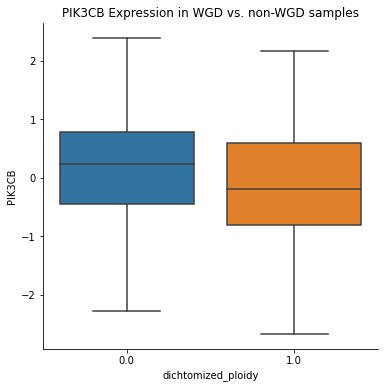

In [71]:
sns.boxplot(data=rna.join(absolute_ploidy_y), y='PIK3CB', x='dichtomized_ploidy', showfliers=False) 
sns.despine()
plt.title('PIK3CB Expression in WGD vs. non-WGD samples')
plt.show()

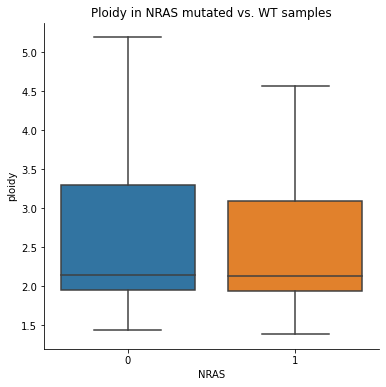

In [72]:
sns.boxplot(data=mut.astype(bool).astype(int).join(absolute_ploidy), y='ploidy', x='NRAS', showfliers=False)
sns.despine()
plt.title('Ploidy in NRAS mutated vs. WT samples')
plt.savefig('../figures/ploidy_LIU_imp_genes_scatter.pdf')
plt.show()

In [62]:
mut.astype(bool).astype(int).join(absolute_ploidy_y).groupby(['dichtomized_ploidy', 'NRAS']).count()

GSTP1  LRRC3B  LZIC  PLCB3  COX18  TNKS  ACSM4  \
dichtomized_ploidy NRAS                                                   
0.0                0       170     170   170    170    170   170    170   
                   1        78      78    78     78     78    78     78   
1.0                0       136     136   136    136    136   136    136   
                   1        46      46    46     46     46    46     46   

                         HMOX1  DDX50  RAB3GAP1  ...  OR11H4  TOP3A  SGSM2  \
dichtomized_ploidy NRAS                          ...                         
0.0                0       170    170       170  ...     170    170    170   
                   1        78     78        78  ...      78     78     78   
1.0                0       136    136       136  ...     136    136    136   
                   1        46     46        46  ...      46     46     46   

                         NRD1  C22orf42  ANKMY2  DKC1  PIH1D1  PBK  CMTM8  
dichtomized_ploidy NRAS                                                    
0.0                0      170       170     170   170     170  170    170  
                   1       78        78      78    78      78   78     78  
1.0                0      136       136     136   136     136  136    136  
                   1       46        46      46    46      46   46     46  

[4 rows x 16720 columns]

In [65]:
46/(78+46)

0.3709677419354839

In [66]:
136/(170+136)

0.4444444444444444

In [63]:
78/(170+78)

0.31451612903225806

In [64]:
46/(136+46)

0.25274725274725274

In [9]:
genetic_data = {'rna': rna, 'mut': mut}

In [10]:
absolute_TCGA = pd.read_csv('/mnt/disks/pancan/data/m1000/TCGA_mastercalls.abs_tables_JSedit.fixed.txt',
                            delimiter='\t', index_col='array')
absolute_ploidy = absolute_TCGA[['ploidy']].join(rna, how='inner')['ploidy']
absolute_ploidy.dropna(inplace=True)

In [11]:
gm = GaussianMixture(n_components=2, random_state=0).fit(absolute_ploidy.values.reshape(-1, 1))
y = gm.predict_proba(np.linspace(0,absolute_ploidy.max(),1000).reshape(-1,1))
ma = np.linspace(0,absolute_ploidy.max(),1000)[y[:,1] < 0.5].max()
absolute_ploidy_y = pd.DataFrame(index=absolute_ploidy.index, columns=['dichtomized_ploidy'],
                               data=[int(p > 2.4) 
                                     for p in absolute_ploidy.values])

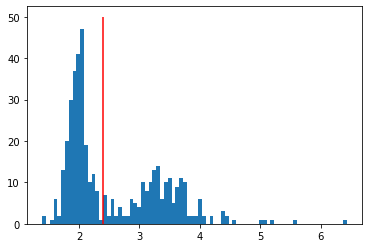

In [12]:
plt.rcParams["figure.figsize"] = (6,4)
plt.hist(absolute_ploidy, bins=80)
plt.vlines([2.4], color='r', ymin=0, ymax=50)
plt.savefig('../figures/ploidy_cutoff_selection.pdf')
plt.show()

In [13]:
absolute_ploidy_y.sum()/absolute_ploidy_y.count()

dichtomized_ploidy    0.422633
dtype: float64

In [14]:
tumor_order = list(tumor.join(absolute_ploidy).groupby('tumor').median().sort_values('ploidy', ascending=False).index)

In [15]:
coloring = (tumor.join(absolute_ploidy).groupby('tumor').median().sort_values('ploidy', ascending=False) > 2.5)

In [16]:
coloring['color'] = coloring['ploidy'].apply(lambda x: 'aquamarine' if x else 'whitesmoke')

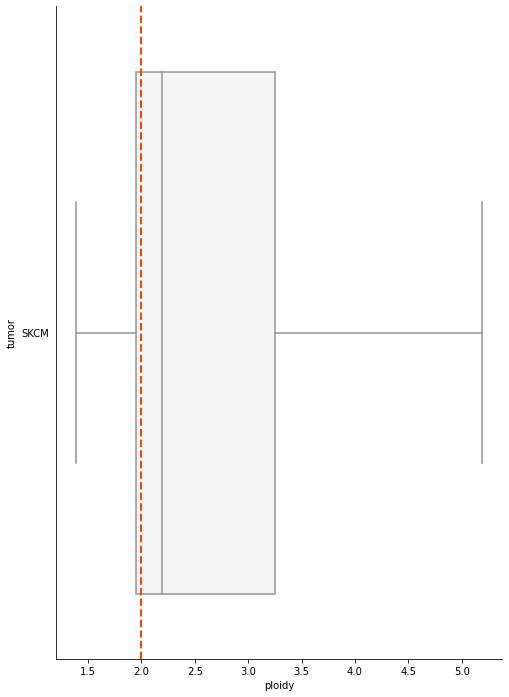

In [17]:
df = tumor.join(absolute_ploidy)
df['tumor'] = [x.upper() for x in list(df['tumor'].values)]
df['coloring'] = coloring['ploidy']
tumor_order = list(df.groupby('tumor').median().sort_values('ploidy', ascending=False).index)
plt.rcParams["figure.figsize"] = (8,12)
sns.boxplot(data=df, x='ploidy', y='tumor', order=tumor_order, color='w', palette=coloring['color'], showfliers=False)
plt.axvline(2, color='orangered', linestyle='--', linewidth=2)
plt.tick_params(axis='y', which='both',  left=False, top=False, labelleft=True)
sns.despine()
plt.savefig('../figures/ploidy_by_tumortype.pdf')

In [18]:
# heterogeneity = pd.read_csv('/mnt/disks/pancan/data/heterogeneity.tsv', delimiter=' ')
# heterogeneity

## Select genes

In [19]:
rna = rna.dropna(axis=1)

In [20]:
pca = PCA(n_components=50)
pca.fit(rna.values)

PCA(n_components=50)

In [21]:
pca_loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), index=rna.columns)

In [22]:
genes_pca = abs(pca_loadings).sum(axis=1).nlargest(1000).index

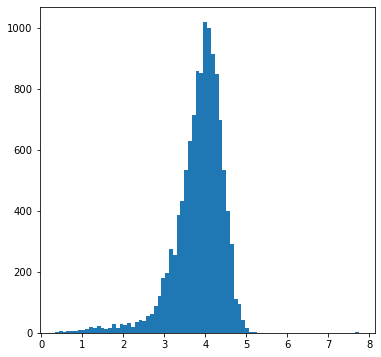

In [23]:
plt.rcParams["figure.figsize"] = (6,6)
plt.hist(abs(pca_loadings).sum(axis=1), bins=80)
plt.show()

## Run pnet

In [24]:
import Pnet

In [25]:
# from sklearn.model_selection import StratifiedKFold

# ploidy_inds = pnet_loader.get_indicies(genetic_data, absolute_ploidy_y)
# y = list(absolute_ploidy_y.loc[ploidy_inds]['dichtomized_ploidy'])
# # Assuming `y` contains the labels for your training data
# # and `prostate_inds` contains the indices of the training data
# # Make sure `y` and `prostate_inds` have the same length

# # Create an instance of StratifiedKFold with 10 splits
# skf = StratifiedKFold(n_splits=10)

# # Initialize an empty list to store the sublists of indices
# sublists = []

# # Split the indices into sublists stratified by labels
# for train_index, _ in skf.split(ploidy_inds, y):
#     sublist = [ploidy_inds[i] for i in train_index]
#     sublists.append(sublist)
    
# for i, s in enumerate(sublists):
#     s_ = [x for x in ploidy_inds if x not in s]
#     train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, absolute_ploidy_y, train_inds=s, test_inds=s_)
#     train_dataset.save_indicies('../data/splits/skcm_ploidy/train_set_{}.csv'.format(i))
#     test_dataset.save_indicies('../data/splits/skcm_ploidy/test_set_{}.csv'.format(i))

In [26]:
canc_genes = list(pd.read_csv('../../pnet_database/genes/cancer_genes.txt').values.reshape(-1))

In [27]:
ext_val_genetic_data = {'rna': rna_ext_val, 'mut': mut_ext_val}
ext_val_ploidy = pd.read_csv('/mnt/disks/pancan/data/mel_dfci_2019/data_clinical_sample.txt',
                             delimiter='\t').set_index('Sample Identifier').iloc[4:]
ext_val_target = pd.DataFrame(ext_val_ploidy['Ploidy'].astype('float') > 2.4).astype('int')

inds = pnet_loader.get_indicies(genetic_data = ext_val_genetic_data,
                                target=ext_val_target)
ext_val_dataset = pnet_loader.PnetDataset(genetic_data = ext_val_genetic_data,
                                          target=ext_val_target, indicies=inds, gene_set=canc_genes)

Found 121 overlapping indicies
Found 565 overlapping genes
generated input DataFrame of size (121, 1130)


Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 430 overlapping indicies
Initializing Train Dataset
Found 565 overlapping genes
generated input DataFrame of size (386, 1130)
Initializing Test Dataset
Found 565 overlapping genes
generated input DataFrame of size (44, 1130)
Found 565 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 430 overlapping indicies
Initializing Train Dataset
Found 565 overlapping genes
generated input DataFrame of size (386, 1130)
Initializing Test Dataset
Found 565 overlapping genes
generated input DataFrame of size (44, 1130)
Found 565 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 430 overlapping indicies
Initializing Train Dataset
Found 565 overlapping genes
gen

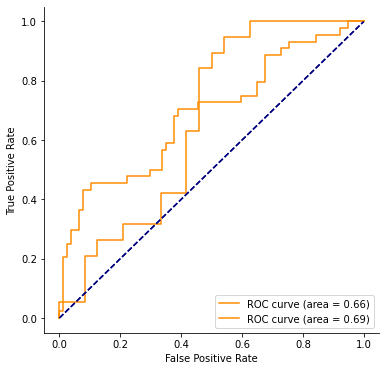

In [28]:
class_weights = util.get_class_weights(torch.tensor(absolute_ploidy_y.values).view(-1))
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/skcm_ploidy/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/skcm_ploidy/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, absolute_ploidy_y, seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3, weight_decay=1e-3,
                                                                               batch_size=64, epochs=400, early_stopping=True, train_inds=train_inds,
                                                                               test_inds=test_inds, loss_weight=class_weights, save_path='../results/ploidy/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/ploidy/tcga_skcm/run{}'.format(i))
    Pnet.evaluate_interpret_save(model, ext_val_dataset, '../results/ploidy/liu_val_skcm/run{}'.format(i))

Given 2 Input modalities
Found 430 overlapping indicies
Initializing Train Dataset
Found 565 overlapping genes
generated input DataFrame of size (386, 1130)
Initializing Test Dataset
Found 565 overlapping genes
generated input DataFrame of size (44, 1130)
Given 2 Input modalities
Found 430 overlapping indicies
Initializing Train Dataset
Found 565 overlapping genes
generated input DataFrame of size (386, 1130)
Initializing Test Dataset
Found 565 overlapping genes
generated input DataFrame of size (44, 1130)
Given 2 Input modalities
Found 430 overlapping indicies
Initializing Train Dataset
Found 565 overlapping genes
generated input DataFrame of size (386, 1130)
Initializing Test Dataset
Found 565 overlapping genes
generated input DataFrame of size (44, 1130)
Given 2 Input modalities
Found 430 overlapping indicies
Initializing Train Dataset
Found 565 overlapping genes
generated input DataFrame of size (388, 1130)
Initializing Test Dataset
Found 565 overlapping genes
generated input DataF

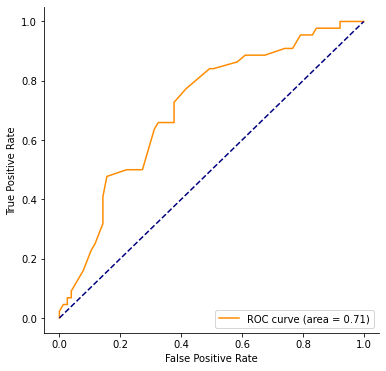

In [29]:
for i in range(10):
    path = '../results/ploidy/tcga_skcm_rf/run{}'.format(i)
    if not os.path.exists(path):
        os.makedirs(path)
    train_inds = list(pd.read_csv('../data/splits/skcm_ploidy/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/skcm_ploidy/test_set_{}.csv'.format(i))['indicies'])
    train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, target=absolute_ploidy_y, train_inds=train_inds, test_inds=test_inds,
                                                                  gene_set=canc_genes)
    
    x_train = train_dataset.x
    additional_train = train_dataset.additional
    y_train = train_dataset.y.ravel()
    x_test = test_dataset.x
    additional_test = test_dataset.additional
    y_test = test_dataset.y.ravel()
    
    rfc = RandomForestClassifier(max_depth=None, random_state=0)
    rfc.fit(x_train, y_train)
    preds = rfc.predict(x_test)
    preds_prob = rfc.predict_proba(x_test)
    plt.clf()
    auc = util.get_auc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test, save=path+'/auc_curve.pdf')
    auc_prc = util.get_auc_prc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test)
    f1_score = util.get_f1(torch.tensor(preds, dtype=torch.float), y_test)
    importances = rfc.feature_importances_
    forest_importances = pd.Series(importances, index=test_dataset.input_df.columns)
    forest_importances.to_csv(path+'/gene_feature_importances.csv')
    torch.save(auc, path+'/AUC.pt')
    torch.save(auc_prc, path+'/AUC_PRC.pt')
    torch.save(f1_score, path+'/F1.pt')
    
    # Val Data evaluation:
    path = '../results/ploidy/liu_val_skcm_rf/run{}'.format(i)
    if not os.path.exists(path):
        os.makedirs(path)
    x_val = ext_val_dataset.x
    additional_val = ext_val_dataset.additional
    y_val = ext_val_dataset.y.ravel()

    preds = rfc.predict(x_val)
    preds_prob = rfc.predict_proba(x_val)
    plt.clf()
    auc = util.get_auc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_val, save=path+'/auc_curve.pdf')
    auc_prc = util.get_auc_prc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_val)
    f1_score = util.get_f1(torch.tensor(preds, dtype=torch.float), y_val)
    importances = rfc.feature_importances_
    forest_importances = pd.Series(importances, index=ext_val_dataset.input_df.columns)
    forest_importances.to_csv(path+'/gene_feature_importances.csv')
    torch.save(auc, path+'/AUC.pt')
    torch.save(auc_prc, path+'/AUC_PRC.pt')
    torch.save(f1_score, path+'/F1.pt')

In [30]:
data_sets = ['tcga_skcm', 'liu_val_skcm', 'tcga_skcm_rf', 'liu_val_skcm_rf']
listl = []
for ds in data_sets:
    for i in range(10):
        auc = torch.load('../results/ploidy/{}/run{}/AUC.pt'.format(ds, i))
        rf = ds.split('_')[-1]
        ds_ = ds.split('_')[0]
        if rf == 'rf':
            listl.append([auc.item(), ds_, 'RF'])
        else:
            listl.append([auc.item(), ds_, 'P-Net'])

auc_df = pd.DataFrame(listl, columns=['AUC', 'Data Set', 'Model'])
auc_df['Data Set'] = auc_df['Data Set'].apply(lambda x: x.upper() if x=='tcga' else x.upper()+' 2019')

In [31]:
auc_df.groupby(['Data Set', 'Model']).mean()

AUC
Data Set Model          
LIU 2019 P-Net  0.632615
         RF     0.697890
TCGA     P-Net  0.651604
         RF     0.687001

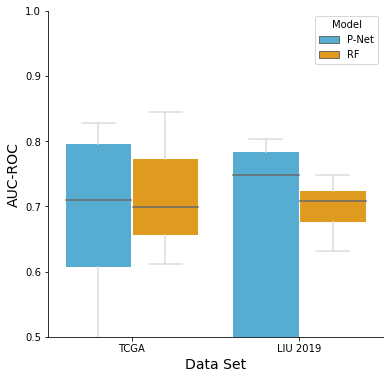

In [32]:
custom_colors = {'P-Net': '#41B6E6', 'RF': '#FFA300'}
sns.boxplot(data=auc_df, y='AUC', x='Data Set', hue='Model', showfliers=False, palette=custom_colors,
                      whiskerprops={'color': 'gainsboro'},
                      capprops={'color': 'gainsboro'},
                        boxprops={'edgecolor': 'none'},
                      medianprops={'color': 'dimgrey'})
ax = plt.gca()

ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('AUC-ROC', size=14)
ax.set_xlabel('Data Set', size=14)
ax.set_ylim((0.5,1))
plt.savefig('../figures/SKCM_ploidy_TCGA_vs_Liu.pdf')
plt.show()

In [31]:
pnet_imps = pd.DataFrame()
pnet_ranks = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/ploidy/liu_val_skcm/run{}/gene_importances.csv'.format(i)).set_index('Unnamed: 0')
    imps = abs(imps.join(ext_val_target).groupby('Ploidy').mean().diff(axis=0).iloc[1])
    ranks = imps.rank(ascending=False)
    pnet_imps['run{}'.format(i)] = imps
    pnet_ranks['run{}'.format(i)] = ranks
    
pnet_imps = (pnet_imps-pnet_imps.mean())/pnet_imps.std()

In [32]:
num_sections = 2
rf_imps = pd.DataFrame()
rf_ranks = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/ploidy/liu_val_skcm_rf/run{}/gene_feature_importances.csv'.format(i)).set_index('Unnamed: 0')
    section_size = len(imps) // num_sections
    dfs = [imps[i * section_size : (i + 1) * section_size] for i in range(num_sections)]
    for df in dfs:
        df.index = [ind.split('_')[0] for ind in dfs[1].index]
    imps = dfs[0] + dfs[1]
    ranks = imps.rank(ascending=False)
    rf_imps['run{}'.format(i)] = imps
    rf_ranks['run{}'.format(i)] = ranks
    
rf_imps = (rf_imps-rf_imps.mean())/rf_imps.std()

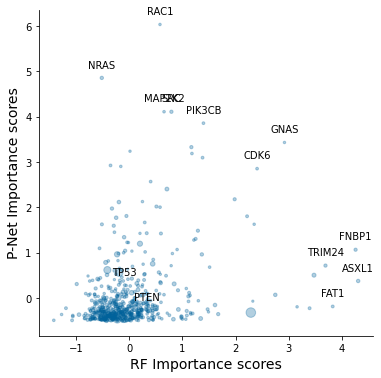

In [33]:
data = {'rf_imps': rf_imps.mean(axis=1), 'pnet_imps': pnet_imps.mean(axis=1)}
df = pd.DataFrame(data)

y_threshold = 2
x_threshold = 2

plt.scatter(df['rf_imps'], df['pnet_imps'], s=1000/(1+pnet_ranks.std(axis=1)).values, alpha=0.3, color='#00629B')

for index, row in df.iterrows():
    if row['pnet_imps'] > y_threshold and row['rf_imps'] > x_threshold:
        plt.annotate(index, (row['rf_imps'], row['pnet_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
    if row['pnet_imps'] > 3.5 or row['rf_imps'] > 3.5:
        plt.annotate(index, (row['rf_imps'], row['pnet_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
        
    if index == 'TP53' or index == 'PTEN':
        plt.annotate(index, (row['rf_imps'], row['pnet_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
plt.xlabel('RF Importance scores', size=14)
plt.ylabel('P-Net Importance scores', size=14)       
sns.despine()
plt.savefig('../figures/SKCM_ploidy_LIU_imp_genes_scatter.pdf')


In [34]:
all_imps = {}
for m in ['tcga_skcm']:
    for l in ['gene_feature', 'gene', 'layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4']:
        df_imps = pd.DataFrame()
        for i in range(10):
            imps = pd.read_csv('../results/ploidy/{}/run{}/{}_importances.csv'.format(m, i, l)).set_index('Unnamed: 0')
            imps = abs(imps.join(absolute_ploidy_y).groupby('dichtomized_ploidy').mean().diff(axis=0).iloc[1])
            df_imps['run{}_{}'.format(i, l)] = imps
        all_imps[l] = df_imps
        all_imps[l] = (all_imps[l]-all_imps[l].mean())/all_imps[l].std()

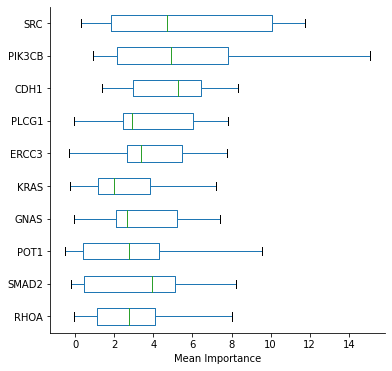

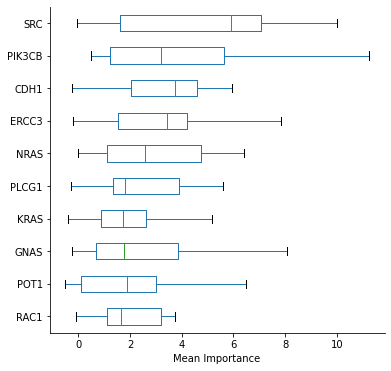

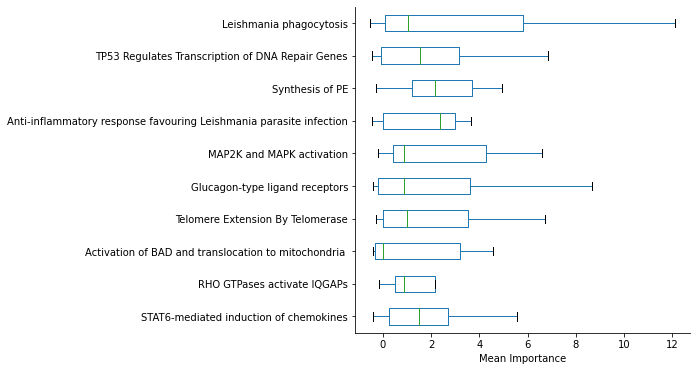

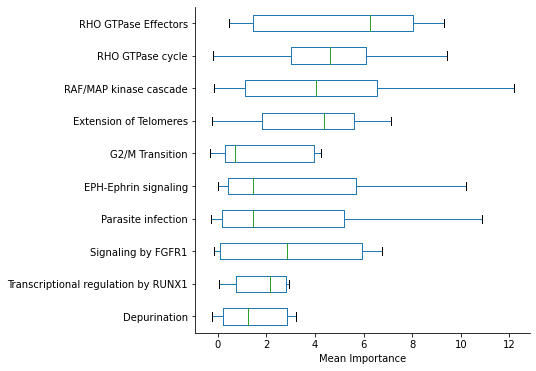

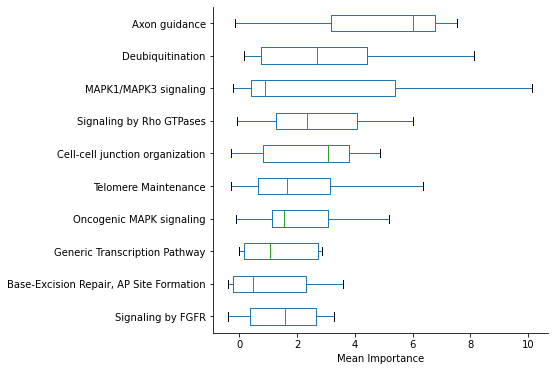

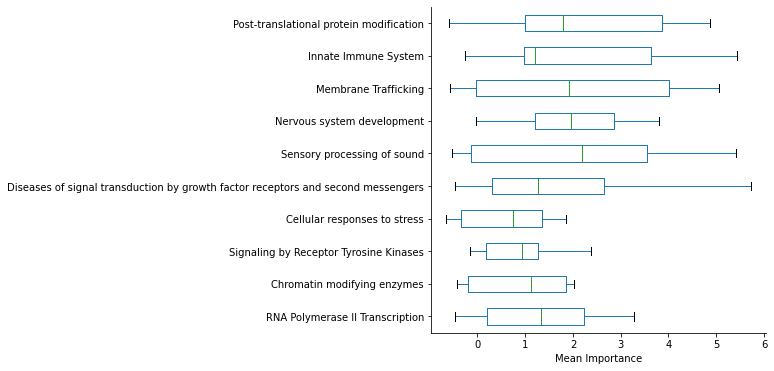

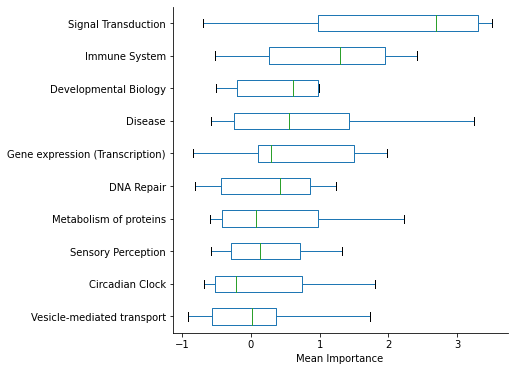

In [35]:
for k in all_imps:
    column_means = all_imps[k].T.mean()
    sorted_columns = column_means.sort_values(ascending=False)
    top_10_columns = sorted_columns[:10].index
    top_columns_df = all_imps[k].T[top_10_columns[::-1]]
    top_columns_df.boxplot(vert=False, showfliers=False)
    plt.xlabel('Mean Importance')
    sns.despine()
    plt.grid(False)
    plt.show()

In [36]:
import gseapy as gp

In [37]:
from gmt_reader import GMT

In [38]:
reactome_gmt = GMT()

In [39]:
reactome_pathways = reactome_gmt.load_data(filename='/mnt/disks/pancan/data/reactome/ReactomePathways.gmt', )

In [40]:
layer_pathways = list(all_imps['layer_4'].index)
filtered_df = reactome_pathways[reactome_pathways['group'].isin(layer_pathways)]
grouped_dict = filtered_df.groupby('group')['gene'].apply(list).to_dict()

In [41]:
reactome_gmt.write_dict_to_file(grouped_dict, '/mnt/disks/pancan/data/reactome/ReactomePathways_l4.gmt')

In [42]:
rf_imps

,run0,run1,run2,run3,run4,run5,run6,run7,run8,run9
TCF12,0.781806,-0.882342,0.461012,-1.084299,0.000406,0.300565,0.665011,1.962792,-0.597621,0.640261
GATA3,-0.119252,2.676845,1.044605,-0.493686,-0.657904,0.389855,-0.273217,0.940547,0.386162,-0.529523
LCP1,-0.435842,0.232398,-0.980153,-0.056599,-0.375214,0.416042,-1.419251,-0.262719,-0.726879,-1.056398
NF2,0.286871,-0.042562,-0.636297,-0.856571,-1.007003,-0.045288,0.028581,0.858568,0.161455,-0.524754
SMARCB1,-0.440109,-0.055559,-0.874450,0.317194,-0.296951,-0.329122,-1.338571,0.130740,-1.181805,2.155555
...,...,...,...,...,...,...,...,...,...,...
EPHA3,-0.129894,2.219156,1.665626,0.525657,0.643280,2.021439,0.312561,2.023823,0.047313,1.509419
PICALM,1.761293,-0.610348,1.279853,0.266296,0.309055,0.783680,1.736317,-0.037704,0.405662,1.031082
TNFRSF14,2.549481,2.135990,-0.387069,0.515121,-0.243634,0.965855,0.685969,1.063291,0.149375,2.350541
MLLT1,-0.484814,-0.689520,-0.262022,-1.102063,0.568673,-1.247102,0.879621,-0.104474,0.261996,-0.320053


In [43]:
rf_all_imps = {}
for i in range(5):
    rf_layer_imps = pd.DataFrame()
    for j in range(10):
        pre_res = gp.prerank(rnk=rf_imps['run{}'.format(j)], # or rnk = rnk,
                         gene_sets='/mnt/disks/pancan/data/reactome/ReactomePathways_l{}.gmt'.format(i),
                         threads=4,
                         min_size=5,
                         max_size=1000,
                         permutation_num=1000, # reduce number to speed up testing
                         outdir=None, # don't write to disk
                         seed=6,
                         verbose=False, # see what's going on behind the scenes
                        )
        pre_res = pd.DataFrame(pre_res.res2d.set_index('Term')['NES'])
        rf_layer_imps['run{}'.format(j)] = pre_res
    rf_all_imps['layer_{}'.format(i)] = rf_layer_imps

2023-08-22 15:21:14,960 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-08-22 15:21:15,184 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-08-22 15:21:17,974 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-08-22 15:21:18,310 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-08-22 15:21:20,775 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-08-22 15:21:21,064 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be

In [44]:
rf_all_imps['layer_0']

,run0,run1,run2,run3,run4,run5,run6,run7,run8,run9
Term,,,,,,,,,,
Interleukin-2 signaling,-1.712151,-0.702022,0.737453,0.690485,-0.844271,0.774936,-1.451749,-0.699127,-1.285612,-1.064643
SUMOylation of chromatin organization proteins,-1.623386,0.463267,-0.887946,-0.918709,0.614516,-0.644513,-0.827893,-1.383629,0.82232,-1.439032
RND2 GTPase cycle,1.514173,1.436522,1.139654,-0.598094,1.588143,1.183881,1.465783,0.851409,0.970216,1.357624
RHOQ GTPase cycle,1.493231,1.183438,1.217082,-0.657595,1.616393,1.361271,1.545827,1.04743,1.036107,1.160183
Regulation of PTEN stability and activity,1.485932,-1.142557,-0.762199,-0.771132,0.568961,-0.974745,-0.80045,0.57488,1.651575,0.624215
...,...,...,...,...,...,...,...,...,...,...
RHOA GTPase cycle,0.50697,0.71349,-1.309066,-1.249716,1.173266,-0.677396,0.585431,-1.551162,-1.590403,-0.962089
NRAGE signals death through JNK,-0.497647,1.038287,-1.194318,-0.965499,0.595792,1.048072,0.744537,0.895356,-1.708814,1.365656
RAC2 GTPase cycle,0.484176,-1.253769,-1.328463,0.865938,1.243173,-0.857548,0.410621,1.077651,-0.570402,0.622653


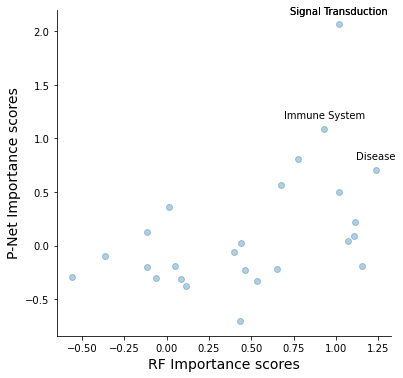

In [45]:
data = {'rf_imps': rf_all_imps['layer_4'].mean(axis=1), 'pnet_imps': all_imps['layer_4'].mean(axis=1)}
df = pd.DataFrame(data)

y_threshold = 1
x_threshold = 0.5

plt.scatter(df['rf_imps'], df['pnet_imps'], alpha=0.3, color='#00629B')

for index, row in df.iterrows():
    if row['pnet_imps'] > y_threshold and row['rf_imps'] > x_threshold:
        plt.annotate(index, (row['rf_imps'], row['pnet_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
    if row['pnet_imps'] > 1.5 or row['rf_imps'] > 1.2:
        plt.annotate(index, (row['rf_imps'], row['pnet_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
        
    if index == 'TP53' or index == 'PTEN':
        plt.annotate(index, (row['rf_imps'], row['pnet_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
plt.xlabel('RF Importance scores', size=14)
plt.ylabel('P-Net Importance scores', size=14)       
sns.despine()
plt.savefig('../figures/SKCM_ploidy_LIU_imp_layer_4_scatter.pdf')


### Hallmark Gene set predictions

Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 430 overlapping indicies
Initializing Train Dataset
Found 565 overlapping genes
generated input DataFrame of size (386, 1130)
Initializing Test Dataset
Found 565 overlapping genes
generated input DataFrame of size (44, 1130)
Found 565 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 430 overlapping indicies
Initializing Train Dataset
Found 565 overlapping genes
generated input DataFrame of size (386, 1130)
Initializing Test Dataset
Found 565 overlapping genes
generated input DataFrame of size (44, 1130)
Found 565 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 430 overlapping indicies
Initializing Train Dataset
Found 565 overlapping genes
gen

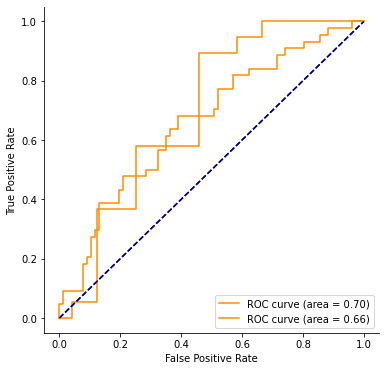

In [103]:
class_weights = util.get_class_weights(torch.tensor(absolute_ploidy_y.values).view(-1))
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/skcm_ploidy/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/skcm_ploidy/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run_geneset(genetic_data, absolute_ploidy_y, 
                                                                                     geneset_path='/mnt/disks/pancan/pnet/data/hallmark/h.all.v2022.1.Hs.symbols.gmt',
                                                                                     seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3, weight_decay=1e-3,
                                                                               batch_size=64, epochs=400, early_stopping=True, train_inds=train_inds,
                                                                               test_inds=test_inds, loss_weight=class_weights, 
                                                                                     save_path='../results/ploidy_hallmark/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), genes=canc_genes)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/ploidy_hallmark/run{}'.format(i))
    Pnet.evaluate_interpret_save(model, ext_val_dataset, '../results/ploidy_hallmark/liu_val_skcm/run{}'.format(i))

In [46]:
data_sets = ['', '/liu_val_skcm']
listl = []
for ds in data_sets:
    for i in range(10):
        auc = torch.load('../results/ploidy_hallmark{}/run{}/AUC.pt'.format(ds, i))
        if ds == '':
            listl.append([auc.item(), 'liu', 'Hallmark-Net'])
        else:
            listl.append([auc.item(), 'tcga', 'Hallmark-Net'])

auc_df_ = pd.DataFrame(listl, columns=['AUC', 'Data Set', 'Model'])
auc_df_['Data Set'] = auc_df_['Data Set'].apply(lambda x: x.upper() if x=='tcga' else x.upper()+' 2019')
auc_df = pd.concat([auc_df, auc_df_])

In [47]:
auc_df.groupby(['Data Set', 'Model']).mean()

AUC
Data Set Model                 
LIU 2019 Hallmark-Net  0.700259
         P-Net         0.739699
         RF            0.705593
TCGA     Hallmark-Net  0.687780
         P-Net         0.738556
         RF            0.665367

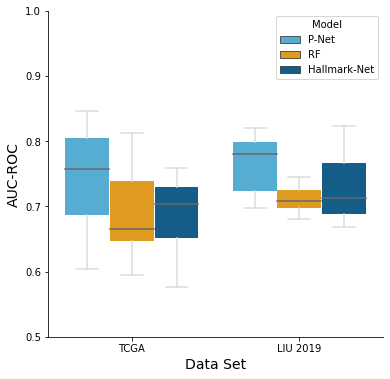

In [48]:
custom_colors = {'P-Net': '#41B6E6', 'RF': '#FFA300', 'Hallmark-Net': '#00629B'}
sns.boxplot(data=auc_df, y='AUC', x='Data Set', hue='Model', showfliers=False, palette=custom_colors,
                      whiskerprops={'color': 'gainsboro'},
                      capprops={'color': 'gainsboro'},
                        boxprops={'edgecolor': 'none'},
                      medianprops={'color': 'dimgrey'})
ax = plt.gca()

ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('AUC-ROC', size=14)
ax.set_xlabel('Data Set', size=14)
ax.set_ylim((0.5,1))
plt.savefig('../figures/SKCM_ploidy_TCGA_vs_Liu.pdf')
plt.show()

In [49]:
hallmark_imps = pd.DataFrame()
hallmark_ranks = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/ploidy_hallmark/liu_val_skcm/run{}/gene_importances.csv'.format(i)).set_index('Unnamed: 0')
    imps = abs(imps.join(ext_val_target).groupby('Ploidy').mean().diff(axis=0).iloc[1])
    ranks = imps.rank(ascending=False)
    hallmark_imps['run{}'.format(i)] = imps
    hallmark_ranks['run{}'.format(i)] = ranks
    
hallmark_imps = (hallmark_imps-hallmark_imps.mean())/hallmark_imps.std()

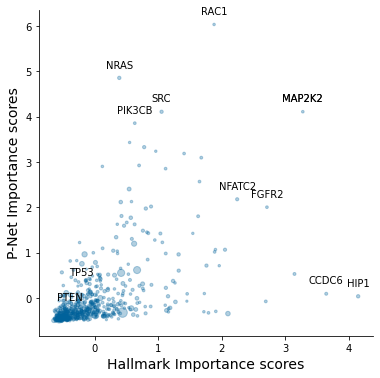

In [50]:
data = {'hallmark_imps': hallmark_imps.mean(axis=1), 'pnet_imps': pnet_imps.mean(axis=1)}
df = pd.DataFrame(data)

y_threshold = 2
x_threshold = 2

plt.scatter(df['hallmark_imps'], df['pnet_imps'], s=1000/(1+pnet_ranks.std(axis=1)).values, alpha=0.3, color='#00629B')

for index, row in df.iterrows():
    if row['pnet_imps'] > y_threshold and row['hallmark_imps'] > x_threshold:
        plt.annotate(index, (row['hallmark_imps'], row['pnet_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
    if row['pnet_imps'] > 3.5 or row['hallmark_imps'] > 3.5:
        plt.annotate(index, (row['hallmark_imps'], row['pnet_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
        
    if index == 'TP53' or index == 'PTEN':
        plt.annotate(index, (row['hallmark_imps'], row['pnet_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
plt.xlabel('Hallmark Importance scores', size=14)
plt.ylabel('P-Net Importance scores', size=14)       
sns.despine()
plt.savefig('../figures/SKCM_ploidy_LIU_imp_genes_scatter_hallmark.pdf')


In [52]:
all_hallmark_imps = {}
for m in ['']:
    for l in ['gene_feature', 'gene', 'layer_0', 'layer_1', 'layer_2']:
        df_imps = pd.DataFrame()
        for i in range(10):
            imps = pd.read_csv('../results/ploidy_hallmark/liu_val_skcm/run{}/{}_importances.csv'.format(i, l)).set_index('Unnamed: 0')
            imps = abs(imps.join(ext_val_target).groupby('Ploidy').mean().diff(axis=0).iloc[1])
            df_imps['run{}_{}'.format(i, l)] = imps
        all_hallmark_imps[l] = df_imps
        all_hallmark_imps[l] = (all_hallmark_imps[l]-all_hallmark_imps[l].mean())/all_hallmark_imps[l].std()

In [56]:
rf_layer_imps = pd.DataFrame()
for j in range(10):
    pre_res = gp.prerank(rnk=rf_imps['run{}'.format(j)], # or rnk = rnk,
                     gene_sets='/mnt/disks/pancan/data/hallmark/h.all.v2022.1.Hs.symbols.gmt',
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=False, # see what's going on behind the scenes
                    )
    pre_res = pd.DataFrame(pre_res.res2d.set_index('Term')['NES'])
    rf_layer_imps['run{}'.format(j)] = pre_res
rf_all_imps['layer_hallmark'.format(i)] = rf_layer_imps

2023-08-22 15:36:25,874 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-08-22 15:36:25,974 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


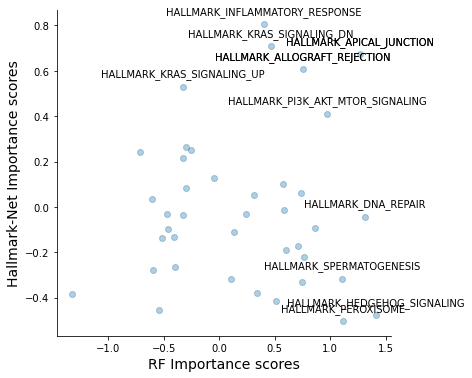

In [63]:
data = {'rf_imps': rf_all_imps['layer_hallmark'].mean(axis=1), 'hallmark_imps': all_hallmark_imps['layer_0'].mean(axis=1)}
df = pd.DataFrame(data)

y_threshold = 0.3
x_threshold = 0.5

plt.scatter(df['rf_imps'], df['hallmark_imps'], alpha=0.3, color='#00629B')

for index, row in df.iterrows():
    if row['hallmark_imps'] > y_threshold and row['rf_imps'] > x_threshold:
        plt.annotate(index, (row['rf_imps'], row['hallmark_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
    if row['hallmark_imps'] > 0.5 or row['rf_imps'] > 1:
        plt.annotate(index, (row['rf_imps'], row['hallmark_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
        
    if index == 'TP53' or index == 'PTEN':
        plt.annotate(index, (row['rf_imps'], row['hallmark_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
plt.xlabel('RF Importance scores', size=14)
plt.ylabel('Hallmark-Net Importance scores', size=14)       
sns.despine()
plt.savefig('../figures/SKCM_ploidy_LIU_imp_layer_0_hallmark_scatter.pdf')


## Leave one (cancer type) out training

In [ ]:
cancer_types = tumor['tumor'].unique()

In [ ]:
leave_one_out_auc = {}
for cancer in cancer_types:
    test_inds = list(tumor[tumor['tumor'] == cancer].index)
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data,
                                                                         absolute_ploidy_y,
                                                                         verbose=True,
                                                                         early_stopping=True,
                                                                            test_inds=test_inds)
    x_test = test_dataset.x
    additional_test = test_dataset.additional
    y_test = test_dataset.y
    model.to('cpu')

    pred = model(x_test, additional_test).detach()
    auc = util.get_auc(pred, y_test)
    leave_one_out_auc[cancer] = auc

In [ ]:
leave_one_out_auc = pd.DataFrame.from_dict(leave_one_out_auc, orient='index')
leave_one_out_auc.columns = ['AUC']
leave_one_out_auc['AUC'] = leave_one_out_auc['AUC'].astype(float)
leave_one_out_auc.index.names = ['tumor']

tvc = pd.DataFrame(tumor.value_counts(), columns=['samples']).reset_index()
tvc = tvc.set_index('tumor')


df = tumor.join(absolute_ploidy)
tmp = df.groupby('tumor').mean()

leave_one_out_auc = leave_one_out_auc.join(tmp, how='inner')
leave_one_out_auc = leave_one_out_auc.join(tvc, how='inner')

In [ ]:
leave_one_out_auc.sort_values('AUC').plot.barh(y='AUC')
plt.xlabel('Leave-one-out-AUC')
plt.axvline(0.5, color='orangered', linestyle='--', linewidth=2)
plt.show()

In [ ]:
leave_one_out_auc.sort_values('ploidy').plot.barh(y='AUC')
plt.xlabel('Leave-one-out-AUC')
plt.axvline(0.5, color='orangered', linestyle='--', linewidth=2)
plt.show()

In [ ]:
leave_one_out_auc.sort_values('samples').plot.barh(y='AUC')
plt.xlabel('Leave-one-out-AUC')
plt.axvline(0.5, color='orangered', linestyle='--', linewidth=2)
plt.show()

In [ ]:
feature_importances, additional_importances = model.integrated_gradients(test_dataset)

In [ ]:
feature_importances.sum().nlargest(20)

In [ ]:
layerwise_imps = model.layerwise_importance(test_dataset)

In [ ]:
for l in layerwise_imps:
    print(l.nlargest(5))

In [ ]:
sns.histplot(data=rna.join(absolute_ploidy_y), x='POC5', hue='dichtomized_ploidy',bins=80,
             stat='density', kde=True, common_norm=False)

In [ ]:
gene_order = high_ploidy_importances.median().sort_values(ascending=True).index
gene_order

In [ ]:
high_ploidy_importances = gene_importances[gene_importances.join(absolute_ploidy_y)['dichtomized_ploidy'] == 1]

In [ ]:
plt.rcParams["figure.figsize"] = (6,8)
high_ploidy_importances[list(gene_order[-20:])].plot(kind='box', vert=False, showfliers=False)
plt.savefig('../figures/genes_ploidy.pdf')
plt.show()

In [ ]:
pathway_importances = model.layerwise_importance(test_dataset)

In [ ]:
for l in pathway_importances:
    print(l.nlargest(5))

In [ ]:
some_genes = ['CBFA2T2', 'DNMT3B', 'MYL9', 'POLR2K', 'RPS27A']
fig, axs = plt.subplots(1, 5, figsize=((15, 5)))
for i, gene in enumerate(some_genes):
    gene = gene.split('_')[0]
    sns.boxplot(data=cna.join(absolute_ploidy), x=gene, y='ploidy', ax=axs[i], showfliers=False)
plt.savefig('../figures/cna_vs_ploiy_top_genes.pdf')
plt.show()

In [ ]:
pred = torch.sigmoid(model(x_test, additional_test))

In [ ]:
pred_ = pd.DataFrame(pred.detach().numpy(), index=test_dataset.input_df.index, columns=['prediction'])

In [ ]:
pred_.join(tumor)

In [ ]:
df['tumor'].values[0].upper()

In [ ]:
df = pred_.join(tumor)
df['tumor'] = [str(x).upper() for x in df['tumor'].values]
tumor_order = list(df.groupby('tumor').median().sort_values('prediction', ascending=False).index)
plt.rcParams["figure.figsize"] = (8,12)
sns.boxplot(df, x='prediction', y='tumor', order=tumor_order, color='w', showfliers=False)
plt.axvline(0.5, color='orangered', linestyle='--', linewidth=2)
plt.tick_params(axis='y', which='both',  left=False, top=False, labelleft=True)
sns.despine()
plt.savefig('../figures/prediction_by_tumortype.pdf')

In [ ]:
missclass_df.groupby('tumor').mean()

In [ ]:
plt.rcParams["figure.figsize"] = (6,6)
missclass_df = pred_.join(tumor).join(test_dataset.target)
missclass_df['misclass'] = missclass_df.apply(lambda x: 1-int(round(x['prediction'])==x['dichtomized_ploidy']), axis=1)
sns.scatterplot(missclass_df.groupby('tumor').mean(), x='dichtomized_ploidy', y='misclass')
for tum in missclass_df.groupby('tumor').mean().index:
    plt.annotate(missclass_df.groupby('tumor').mean().loc[tum].name,
                (missclass_df.groupby('tumor').mean().loc[tum]['dichtomized_ploidy'],
                 missclass_df.groupby('tumor').mean().loc[tum]['misclass']))
plt.savefig('../figures/ploidy_vs_misclass_by_tumortype.pdf')

## Ploidy by cancer type training

In [ ]:
ploidy_range = absolute_ploidy_y.join(tumor).groupby('tumor').mean()['dichtomized_ploidy'].between(0.35,0.65)
cancer_types = tumor['tumor'].unique()
cancer_types = [ct for ct in cancer_types if ploidy_range[ct]]
training_cancer_types = [x for x in cancer_types if (tumor['tumor'].value_counts() > 200)[x]]

df = pd.DataFrame()
df['WGD'] = tumor.join(absolute_ploidy_y).groupby('tumor').sum()['dichtomized_ploidy']
df['DP'] = tumor.join(absolute_ploidy_y).groupby('tumor').count()['dichtomized_ploidy'] - df['WGD']
min_samples = df.loc[training_cancer_types].min().min()

In [ ]:
def stratified_inds(tumor_inds, target, samples_nbr):
    target = target.loc[set(tumor_inds).intersection(target.index)]
    pos_samples = list(target[target[target.columns[0]] == 1].index)
    neg_samples = list(target[target[target.columns[0]] == 0].index)
    random.shuffle(pos_samples)
    random.shuffle(neg_samples)
    train_inds = pos_samples[:samples_nbr] + neg_samples[:samples_nbr]
    test_inds = pos_samples[samples_nbr:] + neg_samples[samples_nbr:]
    return train_inds, test_inds

In [ ]:
canc_spec_auc = {}
for train_cancer in training_cancer_types:
    inds = list(tumor[tumor['tumor'] == train_cancer].index)
    train_inds, test_inds = stratified_inds(inds, absolute_ploidy_y, 100)
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data,
                                                                         absolute_ploidy_y,
                                                                         verbose=False,
                                                                         early_stopping=True,
                                                                                 train_inds=train_inds,
                                                                        test_inds=test_inds)
    val_aucs = []
    for val_cancer in cancer_types:
        print(val_cancer)
        val_inds = list(tumor[tumor['tumor'] == val_cancer].index)
        val_inds = set(val_inds).intersection(pnet_loader.get_indicies(genetic_data, absolute_ploidy_y))
        val_dataset = pnet_loader.PnetDataset(genetic_data, absolute_ploidy_y, val_inds,
                                              additional_data=None, gene_set=None)
        x_val = val_dataset.x
        additional_val = val_dataset.additional
        y_val = val_dataset.y
        model.to('cpu')

        pred = model(x_val, additional_val).detach()
        auc = util.get_auc(pred, y_val)
        val_aucs.append(auc)
    canc_spec_auc[train_cancer] = val_aucs

In [ ]:
cancer_spec_auc_df = pd.DataFrame(canc_spec_auc, index=cancer_types).astype(float)
cancer_spec_auc_df.columns = list([x+'_train' for x in canc_spec_auc.keys()])
cancer_spec_auc_df.to_csv('/mnt/disks/pancan/pnet/results/ploidy/cancer_spec_ploidy_auc.csv')

In [ ]:
sns.clustermap(cancer_spec_auc_df.T, vmin=0, vmax=1, method='ward')

##### Multiple runs

In [ ]:
def fold_run(x, y, n):
    aucs = []
    most_imp_genes = []
    for r in range(n):
        print('run: {}'.format(r))
        model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(x,
                                                                             y,
                                                                             verbose=False,
                                                                             early_stopping=True)

        x_train = train_dataset.input_df.astype(float).values
        additional_train = train_dataset.additional_data.astype(float).values
        y_train = train_dataset.target.astype(float).values.reshape(-1)
        x_test = test_dataset.input_df.astype(float).values
        additional_test = test_dataset.additional_data.astype(float).values
        y_test = test_dataset.target.astype(float).values.reshape(-1)

        pred = model(torch.tensor(x_test, dtype=torch.float),
                                  torch.tensor(additional_test, dtype=torch.float)
                    )
        y_pred_proba = pred.detach().numpy().squeeze()
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        test_auc = metrics.roc_auc_score(y_test, pred.detach().numpy().squeeze())

        aucs.append(test_auc)

        gene_importances, additional_importances = model.deepLIFT(test_dataset)
        most_imp_genes.append(gene_importances.sum())
    return aucs, most_imp_genes

In [ ]:
def fold_run_rf(x, y, n):
    aucs = []
    most_imp_genes = []
    for r in range(n):
        print('run: {}'.format(r))
        train_dataset, test_dataset = pnet_loader.generate_train_test(x, y, None, None, 0.3, None)
        clf = RandomForestClassifier()
        clf.fit(train_dataset.input_df.values, train_dataset.target.values.reshape(-1))
        
        x_train = train_dataset.input_df.astype(float).values
        additional_train = train_dataset.additional_data.astype(float).values
        y_train = train_dataset.target.astype(float).values.reshape(-1)
        x_test = test_dataset.input_df.astype(float).values
        additional_test = test_dataset.additional_data.astype(float).values
        y_test = test_dataset.target.astype(float).values.reshape(-1)

        y_pred_proba = clf.predict_proba(x_test)
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba[:,1])
        test_auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])

        aucs.append(test_auc)

        gene_importances = clf.feature_importances_
        most_imp_genes.append(pd.DataFrame(clf.feature_importances_, index=test_dataset.input_df.columns))
    return aucs, most_imp_genes

In [ ]:
ploidy_absolut_auc, ploidy_absolut_genes = fold_run(genetic_data, absolute_ploidy_y, 10)
ploidy_absolut_auc_rf, ploidy_absolut_genes_rf = fold_run_rf(genetic_data, absolute_ploidy_y, 10)

In [ ]:
data_pnet = [ploidy_absolut_auc]
data_rf = [ploidy_absolut_auc_rf]

ticks = ['ploidy \n by absolut']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    
    
bpl = plt.boxplot(data_pnet, positions=np.array(range(len(data_pnet)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_rf, positions=np.array(range(len(data_pnet)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

plt.plot([], c='#D7191C', label='pnet')
plt.plot([], c='#2C7BB6', label='rf')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
plt.savefig('absolute_ploidy_auc_pnet_vs_rf.pdf')

In [ ]:
ploidy_absolut_genes

In [ ]:
ploidy_absolut_genes_rf

In [ ]:
gene_order = pd.DataFrame(ploidy_absolut_genes).mean().sort_values(ascending=False).index
df_sum = pd.DataFrame(ploidy_absolut_genes)

In [ ]:
gene_order_rf = pd.DataFrame([x[0] for x in ploidy_absolut_genes_rf]).mean().sort_values(ascending=False).index
df_sum_rf = pd.DataFrame([x[0] for x in ploidy_absolut_genes_rf])

In [ ]:
plt.rcParams["figure.figsize"] = (6,8)
df_sum[list(gene_order[:20]) + list(gene_order[-20:])].plot(kind='box', vert=False)
plt.savefig('Ploidy_important_genes.pdf')
plt.show()

In [ ]:
def check_annotate(x, y):
    if y > 1e-3/(x)**1.9 + 1e-3:
        return True
    else:
        return False

In [ ]:
import scipy.stats as ss

In [ ]:
comb_df['pnet_rank'] = ss.rankdata(comb_df['pnet_imp'])
comb_df['rf_rank'] = ss.rankdata(comb_df['rf_imp'])

In [ ]:
comb_df = pd.DataFrame([df_sum.mean(), df_sum_rf.mean()]).T
comb_df.columns = ['pnet_imp', 'rf_imp']
comb_df['pnet_rank'] = len(comb_df['pnet_imp']) - ss.rankdata(abs(comb_df['pnet_imp']))
comb_df['rf_rank'] = len(comb_df['rf_imp']) - ss.rankdata(abs(comb_df['rf_imp']))
comb_df['annotate'] = comb_df.apply(lambda x: x['pnet_rank'] + x['rf_rank'] < 100, axis=1)

In [ ]:
fig, ax = plt.subplots()

ax.scatter(comb_df['pnet_imp'], comb_df['rf_imp'], s=10)

for i in range(len(comb_df)):
    if comb_df.iloc[i]['annotate']:
        ax.annotate(comb_df.iloc[i].name, (comb_df.iloc[i]['pnet_imp'], comb_df.iloc[i]['rf_imp']))

plt.ylabel('rf importance')
plt.xlabel('pnet importance')
plt.title('Ploidy classification gene importance')
plt.savefig('important_genes_ploidy_scatter.pdf')
plt.show()

In [ ]:
import gseapy as gp

In [ ]:
def prerank_gsea(gene_importances, gene_list):
    gene_sets='../data/reactome/ReactomePathways.gmt'
    gene_importance_scores = pd.DataFrame(index=gene_list)
    gene_importance_scores['1'] = gene_importances.values.reshape((2,-1)).sum(axis=0)
        
    pre_res = gp.prerank(rnk=gene_importance_scores,
                         gene_sets = gene_sets,
                         threads=8,
                         min_size=5,
                         max_size=1000,
                         permutation_num=1000,
                         outdir='../prerank_gsea',
                         seed=6,
                         verbose=True
                        )
    return pre_res

In [ ]:
pre_res_rf = prerank_gsea(comb_df['rf_imp'], list(comb_df.iloc[:int(comb_df.shape[0]/2)].index))

In [ ]:
top_hits_rf = list(pre_res_rf.res2d.sort_values('NOM p-val').head(15)['Term'])

In [ ]:
top_hits_rf

In [ ]:
pre_res_pnet = prerank_gsea(comb_df['pnet_imp'], list(comb_df.iloc[:int(comb_df.shape[0]/2)].index))

In [ ]:
top_hits_pnet = list(pre_res_pnet.res2d.sort_values('NOM p-val').head(15)['Term'])

In [ ]:
top_hits_pnet